In [1]:
import tensorflow as tf

class Alexnet:
    def __init__(self, input_size, output_dimension, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size, input_size, 3))
        self.Y = tf.placeholder(tf.float32, (None, output_dimension))
        kernel = tf.Variable(tf.truncated_normal([11, 11, 3, 64], stddev=1e-1))
        bias = tf.Variable(tf.constant(0.0, shape=[64]),trainable=True)
        conv1 = tf.nn.relu(tf.nn.conv2d(self.X, kernel, [1, 4, 4, 1], padding='SAME') + bias)
        lrn1 = tf.nn.local_response_normalization(conv1,
                                              alpha=1e-4,
                                              beta=0.75,
                                              depth_radius=2,
                                              bias=2.0)
        pool1 = tf.nn.max_pool(lrn1,
                         ksize=[1, 3, 3, 1],
                         strides=[1, 2, 2, 1],
                         padding='VALID')
        kernel = tf.Variable(tf.truncated_normal([5, 5, 64, 192], stddev=1e-1))
        bias = tf.Variable(tf.constant(0.0, shape=[192]), trainable=True)
        conv2 = tf.nn.relu(tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME') + bias)
        lrn2 = tf.nn.local_response_normalization(conv2,
                                              alpha=1e-4,
                                              beta=0.75,
                                              depth_radius=2,
                                              bias=2.0)
        pool2 = tf.nn.max_pool(lrn2,
                         ksize=[1, 3, 3, 1],
                         strides=[1, 2, 2, 1],
                         padding='VALID')
        kernel = tf.Variable(tf.truncated_normal([3, 3, 192, 384], stddev=1e-1))
        bias = tf.Variable(tf.constant(0.0, shape=[384]), trainable=True)
        conv3 = tf.nn.relu(tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME') + bias)
        kernel = tf.Variable(tf.truncated_normal([3, 3, 384, 256], stddev=1e-1))
        bias = tf.Variable(tf.constant(0.0, shape=[256]), trainable=True)
        conv4 = tf.nn.relu(tf.nn.conv2d(conv3, kernel, [1, 1, 1, 1], padding='SAME') + bias)
        kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], stddev=1e-1))
        bias = tf.Variable(tf.constant(0.0, shape=[256]), trainable=True)
        conv5 = tf.nn.relu(tf.nn.conv2d(conv4, kernel, [1, 1, 1, 1], padding='SAME') + bias)
        pool5 = tf.nn.max_pool(conv5,
                         ksize=[1, 3, 3, 1],
                         strides=[1, 2, 2, 1],
                         padding='VALID')
        pulled_shape = int(pool5.shape[1]) * int(pool5.shape[2]) * int(pool5.shape[3])
        pulled_pool = tf.reshape(pool5, (-1, pulled_shape))
        w = tf.Variable(tf.truncated_normal([pulled_shape, 4096], stddev=1e-1))
        b = tf.Variable(tf.constant(0.0, shape=[4096]), trainable=True)
        fully1 = tf.nn.relu(tf.matmul(pulled_pool, w) + b)
        w = tf.Variable(tf.truncated_normal([4096, 4096], stddev=1e-1))
        b = tf.Variable(tf.constant(0.0, shape=[4096]), trainable=True)
        fully2 = tf.nn.relu(tf.matmul(fully1, w) + b)
        w = tf.Variable(tf.truncated_normal([4096, output_dimension], stddev=1e-1))
        b = tf.Variable(tf.constant(0.0, shape=[output_dimension]), trainable=True)
        self.logits = tf.matmul(fully2, w) + b
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = self.Y))
        self.optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate).minimize(self.cost)
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, "float"))

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle
from scipy.misc import imresize
from sklearn.cross_validation import train_test_split
from train import train

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo,encoding='latin1')
    return dict

unique_name = unpickle('cifar-10-batches-py/batches.meta')['label_names']
batches = unpickle('cifar-10-batches-py/data_batch_1')
train_X, test_X, train_Y, test_Y = train_test_split(batches['data'], batches['labels'], test_size =0.2)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
BATCH_SIZE = 5
# alexnet original
IMG_SIZE = 224
LEARNING_RATE = 0.0001

In [4]:
sess = tf.InteractiveSession()
model = Alexnet(IMG_SIZE, len(unique_name), LEARNING_RATE)
sess.run(tf.global_variables_initializer())

In [5]:
RESULTS = train(sess, model, 20, BATCH_SIZE, len(unique_name), IMG_SIZE,
               train_X, test_X, train_Y, test_Y)

epoch: 5 accuracy training: 0.577000012388 accuracy testing: 0.334500007592
epoch: 10 accuracy training: 0.622125012651 accuracy testing: 0.358500008024
epoch: 15 accuracy training: 0.656625012727 accuracy testing: 0.373000008389
epoch: 20 accuracy training: 0.678625012683 accuracy testing: 0.378000008389


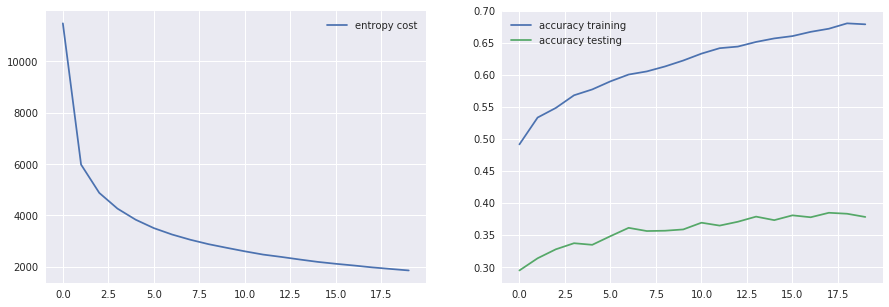

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(RESULTS[0])), RESULTS[0],label='entropy cost')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(RESULTS[0])), RESULTS[1],label='accuracy training')
plt.plot(np.arange(len(RESULTS[0])), RESULTS[2],label='accuracy testing')
plt.legend()
plt.show()